In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.pipeline import Pipeline
from matplotlib import ticker, cm

from swimnetworks import (Dense, Linear)
np.set_printoptions(threshold=np.inf)

In [2]:
def tanh_x(x):
    """First derivative of tanh.
    """
    x = np.clip(x, -10, 10)
    return 1/np.cosh(x)**2

def tanh_xx(x):
    x = np.clip(x, -10, 10)
    return -2*np.tanh(x)*(1-np.tanh(x)**2)


In [11]:
# setup the problem ODE
def u_true(x):
    return np.sin(10*x[:,0]) + np.sin(10*x[:,1])
def u_true_laplacian(x):
    return -100*np.sin(10*x[:,0]) - 100*np.sin(10*x[:,1])



In [12]:
activation = np.tanh
activation_x = tanh_x
activation_xx = tanh_xx

def solve_swim_PINN(domain_train, subdomains, u_true_train, u_grad_train, u_boundary_train, subdomain_layer_widths, random_state=1):
    """Construct a list of PINNs that solve a simple ode over a decomposed domain.
    The ode to solve is $u_x=f(u(x))$, for $x$ in 2D with domain decomposition."""
    # construct good basis functions by sampling activation functions based on the known data
    # we must run over all domains and create models for each
    def fit_model(inner_train, boundary_train, shared_train, i):
        model_ansatz = Pipeline([
            ("hidden", Dense(
                layer_width=subdomain_layer_widths[i],
                activation=activation,
                parameter_sampler='tanh',
                random_seed=random_state)),
            ("linear", Linear(regularization_scale=1e-10))]
        )
        model_ansatz.fit(inner_train, u_grad_train[i])
        # model_ansatz.fit(inner_train, np.zeros_like(u_grad_train[i]))
        # model_ansatz.fit(inner_train, u_true_train[i])

        hidden_layer = model_ansatz.steps[0][1]

        # first, evaluate the gradient of the ansatz function
        hidden_layer.activation = activation_xx

        u_xx = hidden_layer.predict(inner_train) * hidden_layer.weights[0,:] * hidden_layer.weights[0,:]
        u_yy = hidden_layer.predict(inner_train) * hidden_layer.weights[1,:] * hidden_layer.weights[1,:]

        uxy = u_xx + u_yy

        # evaluate it on the boundary as well
        hidden_layer.activation = activation
        u_boundary = np.empty((0,0))
        if not boundary_train is None:
            u_boundary = hidden_layer.predict(boundary_train)

        u_shared = []
        u_shared_gradx = []
        u_shared_grady = []
        if i == 0:
            for j in range(len(domain_train)-1):
                u_shared.append(np.array(hidden_layer.predict(shared_train[j])))
        else:
            u_shared=hidden_layer.predict(shared_train)

        hidden_layer.activation = activation_x
        if i == 0:
            for j in range(len(domain_train)-1):
                u_shared_gradx.append(np.array(hidden_layer.predict(shared_train[j])) * hidden_layer.weights[0,:]) 
                u_shared_grady.append(np.array(hidden_layer.predict(shared_train[j])) * hidden_layer.weights[1,:]) 
        else:
            u_shared_gradx=hidden_layer.predict(shared_train) * hidden_layer.weights[0,:]
            u_shared_grady=hidden_layer.predict(shared_train) * hidden_layer.weights[1,:]

        hidden_layer.activation = activation

        return model_ansatz, uxy, u_boundary, u_shared, u_shared_gradx, u_shared_grady

    model_data = []
    n_rows = 0
    n_columns = 0
    shared_rows = 0

    for i in range(len(domain_train)):
        model_data.append(fit_model(domain_train[i][0], domain_train[i][1], domain_train[i][2], i))
        if i > 0:
            shared_rows += model_data[i][3].shape[0] + model_data[i][4].shape[0] + model_data[i][5].shape[0]

        n_rows += model_data[i][1].shape[0] + model_data[i][2].shape[0]
        n_columns += subdomain_layer_widths[i]+1
    
    print("Model fit using SWIM")
 
    n_rows += shared_rows
    # setup the linear system inputs and outputs
    # also add the bias term
    matrix_in = np.zeros((int(n_rows), n_columns))
    matrix_out = np.empty((0, 1))

    # For gradient and boundary points
    row_start = 0
    column_start = 0
    for i in range(len(domain_train)):
        n_row = model_data[i][1].shape[0]
        matrix_in[row_start:row_start+n_row, column_start:(column_start+subdomain_layer_widths[i]+1)] = np.column_stack([model_data[i][1], np.zeros(model_data[i][1].shape[0])])
        row_start += n_row
        n_row = model_data[i][2].shape[0]
        matrix_in[row_start:row_start+n_row, column_start:(column_start+subdomain_layer_widths[i]+1)] = np.column_stack([model_data[i][2], np.ones(model_data[i][2].shape[0])])
        row_start += n_row
        column_start += subdomain_layer_widths[i]+1

    # For shared points
    column_start = subdomain_layer_widths[0]+1
    for i in range(1, len(domain_train)):    
        n_row = model_data[i][3].shape[0]
        matrix_in[row_start:row_start+n_row, 0:subdomain_layer_widths[0]+1] = np.column_stack([-model_data[0][3][i-1], -np.ones((model_data[0][3][i-1].shape[0],1))])
        matrix_in[row_start:row_start+n_row, column_start:column_start+subdomain_layer_widths[i]+1] = np.column_stack([model_data[i][3], np.ones((model_data[i][3].shape[0],1))])
        row_start += n_row
        column_start += subdomain_layer_widths[i]+1

    column_start = subdomain_layer_widths[0]+1
    for i in range(1, len(domain_train)):    
        n_row = model_data[i][4].shape[0]
        matrix_in[row_start:row_start+n_row, 0:subdomain_layer_widths[0]+1] = np.column_stack([-model_data[0][4][i-1], -np.zeros((model_data[0][4][i-1].shape[0],1))])
        matrix_in[row_start:row_start+n_row, column_start:column_start+subdomain_layer_widths[i]+1] = np.column_stack([model_data[i][4], np.zeros((model_data[i][4].shape[0],1))])
        row_start += n_row
        column_start += subdomain_layer_widths[i]+1

    column_start = subdomain_layer_widths[0]+1
    for i in range(1, len(domain_train)):    
        n_row = model_data[i][5].shape[0]
        matrix_in[row_start:row_start+n_row, 0:subdomain_layer_widths[0]+1] = np.column_stack([-model_data[0][5][i-1], -np.zeros((model_data[0][5][i-1].shape[0],1))])
        matrix_in[row_start:row_start+n_row, column_start:column_start+subdomain_layer_widths[i]+1] = np.column_stack([model_data[i][5], np.zeros((model_data[i][5].shape[0],1))])
        row_start += n_row
        column_start += subdomain_layer_widths[i]+1
            
    print("Matrix_in created")
    # construct the output matrix for gradient and boundary points
    for i in range(len(domain_train)):
        matrix_out = np.row_stack([
            matrix_out,
            u_grad_train[i],
            u_boundary_train[i],
        ])
        # print(u_boundary_train[i])

    # print(matrix_out)
    # # append output matrix for shared points
    matrix_out = np.row_stack([
                    matrix_out,
                    np.zeros((shared_rows,1))
                ])

    print("Matrix_out created")
    print("Solving linear system of equations")
    # solve
    c = np.linalg.lstsq(matrix_in, matrix_out, rcond=1e-10)[0]

    print("Solving completed")
    row_start = 0
    c_subdomain = []
    for i in range(len(domain_train)):
        c_subdomain.append(c[row_start:row_start+subdomain_layer_widths[i]+1])
        model_data[i][0].steps[1][1].weights = c_subdomain[i][:-1]
        model_data[i][0].steps[1][1].biases = c_subdomain[i][-1]
        row_start += subdomain_layer_widths[i]+1

    

    def combined_model(points):
        x = points[:,0]
        y = points[:,1]
        model_pred = np.zeros((points.shape[0],1))
        mask_domain = np.ones((points.shape[0],1), dtype=bool)
        print(mask_domain.shape)
        for i in range(len(subdomains)):
            if subdomains[i]["type"] == "rectangle": 
                vertices = np.array(subdomains[i]["vertices"])
                mask = (vertices[0][0] < x) & (x < vertices[2][0]) & (y > vertices[0][1]) & (y < vertices[2][1])
                mask = mask.reshape(-1,1)
                mask_domain = mask_domain * (~mask) 
                model_pred += model_data[i+1][0].predict(points) * mask
            if subdomains[i]["type"] == "circle":
                center = np.array(subdomains[i]["center"])
                radius = subdomains[i]["radius"]
                mask = np.array(np.linalg.norm(points - center, axis=1) <= radius)
                mask = mask.reshape(-1,1)
                mask_domain = mask_domain * (~mask)
                model_pred += model_data[i+1][0].predict(points) * mask

        model_pred += model_data[0][0].predict(points) * mask_domain
        
        return model_pred

    return combined_model



(-3.4557519189487724,
 3.4557519189487724,
 -3.4557519189487724,
 3.4557519189487724)

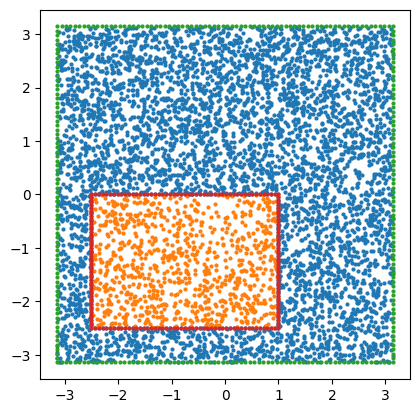

In [21]:
random_state = 1
rng = np.random.default_rng(random_state)

domain_type = "square" 
domain_center = (0, 0)
domain_radius = np.pi

domain = {
    "type"    : "rectangle", 
    "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]
}
# {"type": "circle", "center": (0, 0), "radius": np.pi}

subdomains = [
    {"type": "rectangle", "vertices": [(-2.5, -2.5), (-2.5, 0), (1, 0), (1, -2.5)]},
    # # {"type": "circle", "center": (0, 0), "radius": 0.5},
    # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
]

def is_inside_subdomain(point, subdomain):
    if subdomain["type"] == "rectangle":
        vertices = np.array(subdomain["vertices"])
        return np.all(vertices[0] < point) and np.all(point < vertices[2])
    elif subdomain["type"] == "circle":
        center = np.array(subdomain["center"])
        radius = subdomain["radius"]
        return np.linalg.norm(point - center) < radius
    else:
        return False

def generate_points_domain(domain, subdomains, num_points):
    points = []
    while len(points) < num_points:
        point = rng.uniform(
            low=(domain["vertices"][0]),
            high=(domain["vertices"][2]),
        )
        if not any(is_inside_subdomain(point, subdomain) for subdomain in subdomains):
            points.append(point)
    return points

def generate_points_subdomain(subdomain, num_points):
    if subdomain["type"] == "rectangle":
        vertices = np.array(subdomain["vertices"])
        min_x, min_y = np.min(vertices, axis=0)
        max_x, max_y = np.max(vertices, axis=0)
        points = rng.uniform(low=(min_x, min_y), high=(max_x, max_y), size=(num_points, 2))
    elif subdomain["type"] == "circle":
        center = np.array(subdomain["center"])
        radius = subdomain["radius"]
        r = np.sqrt(rng.uniform(0, 1, size=num_points)) * radius
        theta = rng.uniform(0, 2 * np.pi, size=num_points)
        points = center + np.column_stack((r * np.cos(theta), r * np.sin(theta)))
    else:
        points = np.array([])  
    return points

def generate_boundary_points(subdomain, num_points=20):
    boundary_points = []
    if subdomain["type"] == "rectangle":
        vertices = np.array(subdomain["vertices"])
        for i in range(len(vertices)):
            p1 = vertices[i]
            p2 = vertices[(i + 1) % len(vertices)]
            boundary_points.extend(
                [p1 + t * (p2 - p1) for t in np.linspace(0, 1, int(num_points/4), endpoint=False)]
            )
        boundary_points = np.array(boundary_points)
    elif subdomain["type"] == "circle":
        theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        boundary_points = subdomain["center"] + subdomain["radius"] * np.column_stack((np.cos(theta), np.sin(theta)))
    else:
        boundary_points = []  
    return boundary_points

num_points_domain = 5000
num_pts_boundary = 300 # For square domain should be divisble by 4 

num_points_subdomain = [900, 300, 200]
num_points_shared = [200, 80]  # For sqaure subdomain should be divisble by 4

domain_train_points = []
subdomain_train_points = []
points_domain = generate_points_domain(domain, subdomains, num_points_domain)
points_domain = np.array(points_domain)

boundary_points_domain = generate_boundary_points(domain, int(num_pts_boundary))
boundary_points_domain = np.array(boundary_points_domain)

shared_points_subdomain = []
i=0
boundary_points_subdomain = None
for subdomain in subdomains:
    points_subdomain = []
    temp_subdomain_train_points = []
    points_subdomain = generate_points_subdomain(subdomain, num_points_subdomain[i])
    points_subdomain = np.array(points_subdomain)
    # points_subdomain = np.row_stack([points_subdomain, np.array(generate_boundary_points(subdomain, num_points_shared[i]))])
    temp_subdomain_train_points.append(points_subdomain)
    temp_subdomain_train_points.append(boundary_points_subdomain)
    temp_subdomain_train_points.append(np.array(generate_boundary_points(subdomain, num_points_shared[i])))
    shared_points_subdomain.append(np.array(generate_boundary_points(subdomain, num_points_shared[i])))
    subdomain_train_points.append(temp_subdomain_train_points)
    points_domain = np.row_stack([points_domain, shared_points_subdomain[i]])
    i = i+1

domain_train_points.append(points_domain)
domain_train_points.append(boundary_points_domain)
domain_train_points.append(shared_points_subdomain)
domain_train_points = [domain_train_points]+subdomain_train_points

for i in range(len(subdomains)+1):
    x_coords = [point[0] for point in domain_train_points[i][0]]
    y_coords = [point[1] for point in domain_train_points[i][0]]
    plt.scatter(x_coords, y_coords, s=4)

x_coords = [point[0] for point in domain_train_points[0][1]]
y_coords = [point[1] for point in domain_train_points[0][1]]

plt.scatter(x_coords, y_coords, s=4)


for i in range(len(subdomains)):
    x_coords = [point[0] for point in domain_train_points[i+1][2]]
    y_coords = [point[1] for point in domain_train_points[i+1][2]]
    plt.scatter(x_coords, y_coords, s=4)

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

plt.axis('square')



In [14]:
u_laplacian_train = []
u_true_train = []
u_boundary_train = []

for i in range(len(subdomains)+1):
    u_laplacian_train.append(u_true_laplacian(domain_train_points[i][0]).reshape((-1,1)))
    
    u_true_train.append(u_true(domain_train_points[i][0]).reshape((-1,1)))
    if not domain_train_points[i][1] is None: 
        u_boundary_train.append(u_true(domain_train_points[i][1]).reshape((-1,1)))
    else:
        u_boundary_train.append(np.empty((0,1)))


In [15]:
# layer_widths = np.linspace(10, 100, 5).astype(int)
subdomain_layer_widths = [7000,700,300]
# fig, ax = plt.subplots(1, len(layer_widths), figsize=(20, 3), sharey=True)

error = []
t0 = time()

model = solve_swim_PINN(domain_train_points, subdomains, u_true_train, u_laplacian_train, u_boundary_train, subdomain_layer_widths, random_state=1)
print("time for solving", time()-t0, "seconds.")

Model fit using SWIM
Matrix_in created
Matrix_out created
Solving linear system of equations
Solving completed
time for solving 125.44059705734253 seconds.


(22500, 1)
Maximum error:  [0.00020126]


Text(0, 0.5, 'y')

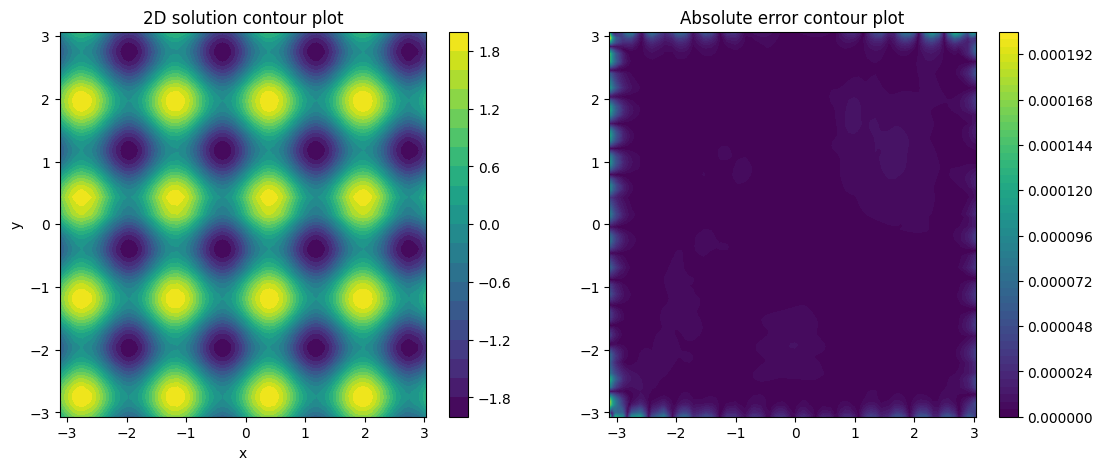

In [9]:
rng = np.random.default_rng(2)
lims = [-1*np.pi, 1*np.pi]
n_pts_train = 150
x = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
y = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
x_t, y_t = np.meshgrid(x, y)

# solution_1 = np.zeros_like(x_t)
solution = model(np.column_stack([x_t.reshape(-1,1), y_t.reshape(-1,1)]))

error = np.absolute(u_true(np.column_stack([x_t.reshape(-1,1), y_t.reshape(-1,1)])).reshape(-1,1) - solution)
print("Maximum error: ",max(error))
error = error.reshape(n_pts_train, n_pts_train)

solution = solution.reshape(n_pts_train, n_pts_train)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
contour1 = ax[0].contourf(x_t, y_t, solution, levels=20, cmap='viridis')
contour2 = ax[1].contourf(x_t, y_t, error, levels=50, cmap = 'viridis') 

colorbar = plt.colorbar(contour1, ax=ax[0])
colorbar = plt.colorbar(contour2, ax=ax[1])

ax[0].set_title('2D solution contour plot')
ax[1].set_title('Absolute error contour plot')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')